In [18]:
!pip install langchain_openai langchain_community chromadb langchain_text_splitters unstructured slackclient langgraph
!pip install --upgrade nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 28.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.7/274.7 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.6/114.6 kB 8.4 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993221 sha256=d4013657a9a360e93a39590c5c54ef088fc2cbd44cb17fb45cbf6f4b55e9d470
  Stor

In [2]:
import getpass
import os

if not os.getenv("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

if not os.getenv("SLACK_TOKEN"):
    os.environ["SLACK_TOKEN"] = getpass.getpass("Enter your slack toekn: ")

Enter your OpenAI API key: ··········


In [12]:
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import DirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain_openai import ChatOpenAI
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor

openai_embedding = OpenAIEmbeddings(model="text-embedding-3-large")
openai_llm = ChatOpenAI(model="gpt-4o-mini",temperature=0,max_tokens=None,timeout=None,max_retries=2)
compressor = LLMChainExtractor.from_llm(openai_llm)

def create_retriever(directory_path):
    loader = DirectoryLoader(directory_path, show_progress=True, use_multithreading=True, silent_errors=True, loader_kwargs={"autodetect_encoding": True})
    docs_list = loader.load()

    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=250, chunk_overlap=0
    )
    doc_splits = text_splitter.split_documents(docs_list)

    # Add to vectorDB
    vectorstore = Chroma.from_documents(
        documents=doc_splits,
        collection_name="rag-chroma",
        embedding=openai_embedding,
    )

    retriever = MultiQueryRetriever.from_llm(retriever=vectorstore.as_retriever(), llm=openai_llm)
    compression_retriever = ContextualCompressionRetriever(base_compressor=compressor, base_retriever=retriever)

    return compression_retriever

In [5]:
!mkdir -p docs/

In [6]:
%%writefile docs/sachin_tendulkar.txt
We have often heard that ‘Cricket is religion in India and Sachin is God’.
There is no better statement that can justify the status of Sachin Tendulkar in India.
Sachin Tendulkar in India is not just a cricketer, he is God. Also for common people in India, he is an example of hard work and determination.
Thus, he is worshipped by everyone in India.

Overwriting docs/sachin_tendulkar.txt


In [7]:
%%writefile docs/virat_kohli.txt
Virat Kohli, often regarded as one of the greatest cricketers of our time, is known for his exceptional batting prowess and leadership skills.
Born on November 5, 1988, in Delhi, Kohli’s passion for cricket bloomed at a young age.
With an impressive batting style and incredible leadership qualities, he has become one of the most admired and accomplished players in the world.
His ability to read the game and make quick decisions showcases his profound intelligence.
Kohli’s comprehension of the sport is evident through his consistent performance, astute game-plans, and adaptability to various formats.
Through his hard work and perseverance, he has earned numerous accolades and continues to inspire aspiring cricketers worldwide.

Overwriting docs/virat_kohli.txt


In [8]:
directory_path = '/content/docs'
retriever = create_retriever(directory_path)
retriever

100%|██████████| 2/2 [00:02<00:00,  1.45s/it]


ContextualCompressionRetriever(base_compressor=LLMChainExtractor(llm_chain=PromptTemplate(input_variables=['context', 'question'], input_types={}, output_parser=NoOutputParser(), partial_variables={}, template='Given the following question and context, extract any part of the context *AS IS* that is relevant to answer the question. If none of the context is relevant return NO_OUTPUT. \n\nRemember, *DO NOT* edit the extracted parts of the context.\n\n> Question: {question}\n> Context:\n>>>\n{context}\n>>>\nExtracted relevant parts:')
| ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x79684415d270>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x79684415f370>, root_client=<openai.OpenAI object at 0x7968441ebd60>, root_async_client=<openai.AsyncOpenAI object at 0x79684415d2d0>, temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********'))
| NoOutputParser(), get_input=<function default_get_input at 0x7968445929e0>), bas

In [13]:
question = 'when was virat kohli born?'
relevant_docs = retriever.get_relevant_documents(question)
relevant_docs

[Document(metadata={'source': '/content/docs/virat_kohli.txt'}, page_content='Born on November 5, 1988')]

In [102]:
relevant_docs[0].page_content

'Born on November 5, 1988'

In [14]:
openai_llm

ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x7968109bf2e0>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x7968444c94e0>, root_client=<openai.OpenAI object at 0x7968129c5f90>, root_async_client=<openai.AsyncOpenAI object at 0x7968109bf550>, model_name='gpt-4o-mini', temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********'))

In [15]:
from langchain.prompts import (
    PromptTemplate,
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)

def get_prompt_tamplate(system_prompt,system_prompt_variables,human_prompt,human_prompt_variables):
    system_prompt = PromptTemplate(input_variables = system_prompt_variables, template=system_prompt)
    system_message_prompt = SystemMessagePromptTemplate(prompt=system_prompt)

    human_prompt = PromptTemplate(input_variables=human_prompt_variables,template=human_prompt)
    human_message_prompt = HumanMessagePromptTemplate(prompt=human_prompt)

    chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, human_message_prompt])
    return chat_prompt

def create_chain(system_prompt,system_prompt_variables,human_prompt,human_prompt_variables,structured_llm):
    chat_prompt = get_prompt_tamplate(system_prompt,system_prompt_variables,human_prompt,human_prompt_variables)
    chain = chat_prompt | structured_llm
    return chain

In [37]:
from langchain_core.pydantic_v1 import BaseModel, Field

class QueryResolver(BaseModel):
    answer: str = Field(description="Answer to the user query based on context")
    slack_post: bool = Field(description="Whether user has asked to add answer to slack")

def get_query_resolver_chain():
    structured_llm = openai_llm.with_structured_output(QueryResolver)
    system_prompt = 'You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don\'t find the relevant answer from context, just say that question is out of context.'
    system_prompt_variables = []

    human_prompt = ''
    human_prompt += "\n<<User query>>:\n{query}\n"
    human_prompt += '\n' + '###' * 30
    human_prompt += "\n<<Context>>:\n{context}\n"
    human_prompt_variables = ['query','context']

    chain = create_chain(system_prompt,system_prompt_variables,human_prompt,human_prompt_variables,structured_llm)
    return chain

In [38]:
query_resolver_chain = get_query_resolver_chain()
query_resolver_input = {'query':"when was virat kohli born",'context':[context.page_content for context in relevant_docs]}
query_resolver_results = query_resolver_chain.invoke(query_resolver_input)
query_resolver_results

QueryResolver(answer='Virat Kohli was born on November 5, 1988.', slack_post=False)

In [39]:
query_resolver_chain = get_query_resolver_chain()
query_resolver_input = {'query':"when was virat kohli born. Post answer on slack",'context':[context.page_content for context in relevant_docs]}
query_resolver_results = query_resolver_chain.invoke(query_resolver_input)
query_resolver_results

QueryResolver(answer='Virat Kohli was born on November 5, 1988.', slack_post=True)

In [31]:
query_resolver_chain = get_query_resolver_chain()
query_resolver_input = {'query':"who is sachin kohli",'context':[context.page_content for context in relevant_docs]}
query_resolver_results = query_resolver_chain.invoke(query_resolver_input)
query_resolver_results

QueryResolver(answer='The context does not provide any information about Sachin Kohli other than his birth date, which is November 5, 1988. Therefore, I cannot provide further details about him.')

In [19]:
from langchain_core.pydantic_v1 import BaseModel, Field

class Hallucination(BaseModel):
    score: bool = Field(description="whether the answer is grounded in supported by a set of facts")

def get_hallucination_chain():
    structured_llm = openai_llm.with_structured_output(Hallucination)
    system_prompt = 'You are a Hallucination Evaluator. Your role is to evaluate whether a given answer is based on or supported by a set of facts.'
    system_prompt_variables = []

    human_prompt = ''
    human_prompt += "\n<<Facts>>:\n{documents}\n"
    human_prompt += '\n' + '###' * 30
    human_prompt += "\n<<Answer>>:\n{answer}\n"
    human_prompt_variables = ['documents','answer']

    chain = create_chain(system_prompt,system_prompt_variables,human_prompt,human_prompt_variables,structured_llm)
    return chain

In [22]:
hallucination_chain = get_hallucination_chain()
hallucination_input = {'documents':relevant_docs,'answer':"virat kohli was born on november"}
hallucination_results = hallucination_chain.invoke(hallucination_input)
hallucination_results

Hallucination(score=True)

In [21]:
hallucination_chain = get_hallucination_chain()
hallucination_input = {'documents':relevant_docs,'answer':"virat kohli is great cricketer"}
hallucination_results = hallucination_chain.invoke(hallucination_input)
hallucination_results

Hallucination(score=False)

Enter your slack toekn: ··········


In [40]:
import slack
client = slack.WebClient(token=os.getenv("SLACK_TOKEN"))
client.chat_postMessage(channel='#test',text='hello\n\nhello\thello')

In [43]:
def add_message_to_slack(message):
    client.chat_postMessage(channel='#test',text=message)

In [80]:
from typing_extensions import TypedDict
from pprint import pprint
from typing import List

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM answer
        documents: list of documents
    """

    question: str
    answer: str
    documents: List[str]
    hallucination: bool
    slack_post: bool

In [93]:
def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)

    print(documents)
    return {"documents": documents, "question": question}

def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, answer and slack_post, that contains LLM answer
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    llm_response = dict(query_resolver_chain.invoke({"context": documents, "query": question}))
    print(llm_response)
    answer = llm_response["answer"]
    slack_post = llm_response["slack_post"]


    return {"documents": documents, "question": question, "answer": answer, "slack_post": slack_post, "hallucination": False}

def check_hallucination(state):
    """
    Check if answer is hallucinated

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, hallucination, that contains hallucination check
    """

    question = state["question"]
    documents = state["documents"]
    answer = state["answer"]
    slack_post = state["slack_post"]

    # Hallucination check
    hallucination_check = dict(hallucination_chain.invoke({"documents": documents, "answer": answer}))
    print(hallucination_check)
    return {"documents": documents, "question": question, "answer": answer, "hallucination": state["hallucination"], "slack_post": slack_post}


def push_to_slack(state):
    """
    Push answer to slack

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, answer, that contains LLM answer
    """
    print("---PUSH TO SLACK---")

    question = state["question"]
    documents = state["documents"]
    answer = state["answer"]
    slack_post = state["slack_post"]
    hallucination = state["hallucination"]

    if not hallucination:
        if slack_post:
            message = f"Question: {question}\nAnswer: {answer}"
            add_message_to_slack(message)

    return {"documents": documents, "question": question, "answer": answer, "hallucination": state["hallucination"], "slack_post": slack_post}

In [94]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("generate", generate)  # generatae
workflow.add_node("check_hallucination", check_hallucination)  # check_hallucination
workflow.add_node("push_to_slack", push_to_slack)  # push to slack

In [95]:
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "generate")
workflow.add_edge("generate", "check_hallucination")
workflow.add_edge("check_hallucination", "push_to_slack")
workflow.set_finish_point("push_to_slack")

In [96]:
# Compile
app = workflow.compile()

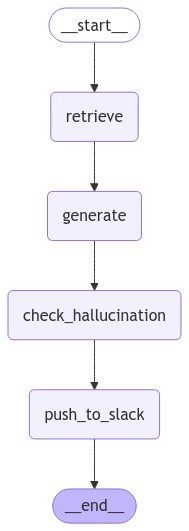

In [97]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [98]:
inputs = {"question": "Who is virat kohli?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["answer"])

---RETRIEVE---


[Document(metadata={'source': '/content/docs/virat_kohli.txt'}, page_content='Virat Kohli, often regarded as one of the greatest cricketers of our time, is known for his exceptional batting prowess and leadership skills. Born on November 5, 1988, in Delhi.')]
'Finished running: retrieve:'
---GENERATE---
{'answer': 'Virat Kohli is often regarded as one of the greatest cricketers of our time, known for his exceptional batting prowess and leadership skills. He was born on November 5, 1988, in Delhi.', 'slack_post': False}
'Finished running: generate:'
{'score': True}
'Finished running: check_hallucination:'
---PUSH TO SLACK---
'Finished running: push_to_slack:'
('Virat Kohli is often regarded as one of the greatest cricketers of our time, '
 'known for his exceptional batting prowess and leadership skills. He was born '
 'on November 5, 1988, in Delhi.')


In [99]:
inputs = {"question": "Who is virat kohli?"}
result = app.invoke(inputs)
print(result)

---RETRIEVE---


[Document(metadata={'source': '/content/docs/virat_kohli.txt'}, page_content='Virat Kohli, often regarded as one of the greatest cricketers of our time, is known for his exceptional batting prowess and leadership skills. Born on November 5, 1988, in Delhi, Kohli’s passion for cricket bloomed at a young age.')]
---GENERATE---
{'answer': 'Virat Kohli is often regarded as one of the greatest cricketers of our time, known for his exceptional batting prowess and leadership skills. He was born on November 5, 1988, in Delhi, and his passion for cricket bloomed at a young age.', 'slack_post': False}
{'score': True}
---PUSH TO SLACK---
{'question': 'Who is virat kohli?', 'answer': 'Virat Kohli is often regarded as one of the greatest cricketers of our time, known for his exceptional batting prowess and leadership skills. He was born on November 5, 1988, in Delhi, and his passion for cricket bloomed at a young age.', 'documents': [Document(metadata={'source': '/content/docs/virat_kohli.txt'}, pa

In [100]:
inputs = {"question": "Who is virat kohli?Push this message on slack"}
result = app.invoke(inputs)
print(result)

---RETRIEVE---


[Document(metadata={'source': '/content/docs/virat_kohli.txt'}, page_content='Virat Kohli, often regarded as one of the greatest cricketers of our time, is known for his exceptional batting prowess and leadership skills. Born on November 5, 1988, in Delhi, Kohli’s passion for cricket bloomed at a young age.')]
---GENERATE---
{'answer': 'Virat Kohli, often regarded as one of the greatest cricketers of our time, is known for his exceptional batting prowess and leadership skills. Born on November 5, 1988, in Delhi, Kohli’s passion for cricket bloomed at a young age.', 'slack_post': True}
{'score': True}
---PUSH TO SLACK---
{'question': 'Who is virat kohli?Push this message on slack', 'answer': 'Virat Kohli, often regarded as one of the greatest cricketers of our time, is known for his exceptional batting prowess and leadership skills. Born on November 5, 1988, in Delhi, Kohli’s passion for cricket bloomed at a young age.', 'documents': [Document(metadata={'source': '/content/docs/virat_ko